# Dataset

In [1]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer, TrainingArguments, pipeline, DataCollatorForSeq2Seq
from peft import LoraConfig, AutoPeftModelForCausalLM, PeftModel, PeftConfig
# from optimum.pipelines import pipeline
from trl import SFTTrainer, setup_chat_format
import os
import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
import gc
from datetime import datetime
from tqdm.auto import tqdm, trange
import numpy as np


2024-05-01 18:05:47.028853: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-01 18:05:47.077467: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-01 18:05:47.775545: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
comet_ml is installed but `COMET_API_KEY` is not set.


## Set Seed

In [2]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

## Set Seed
set_seed(20240501)

## Device

In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

## Load Data

In [4]:
data_path = 'data'
train_df = pd.read_csv(os.path.join(data_path,'train_ir.csv'))
val_df = pd.read_csv(os.path.join(data_path,'val_ir.csv'))
test_df = pd.read_csv(os.path.join(data_path,'test_ir.csv'))

In [5]:
train_df.head()

,answer,question,domain
0,건강한 사람이 에너지 균형을 평형 상태로 유지하는 것은 중요합니다. 에너지 균형은 ...,"에너지 균형이란 무엇이며, 왜 건강에 중요한가요?",nutrition
1,"수소, 산소, 질소 가스의 혼합물에서 평균 속도가 가장 빠른 분자는 수소입니다. 수...",수소 분자가 다른 분자들보다 더 빠르게 움직이는 이유는 무엇인가요?,conceptual_physics
2,종이와 플라스틱은 재활용 가능한 자원입니다. 중학교 과학 수업에서 우리는 종이와 플...,종이와 플라스틱이 재활용 가능한 이유는 무엇인가요?,ARC_Challenge
3,마이애미파랑나비는 남부 플로리다에서 멸종 위기에 처한 종입니다. 이 나비의 개체수 ...,마이애미파랑나비의 주택 건설 증가에 대한 영향은 어떻게 나타나고 있나요?,ARC_Challenge
4,"AIDS에 직면한 민족문화 공동체 연구에 따르면, 한 해 동안 섹스 파트너가 한 명...",성 건강 및 성 문화에 대한 연구에서 발견된 주요 결과는 무엇인가요?,human_sexuality


In [6]:
val_df.head()

,answer,question,domain
0,"비버는 나무를 베고, 덤불과 관목을 모아 강과 개울에 댐을 만드는 것으로 알려져 있...",비버는 왜 나무를 베고 댐을 만드는 것으로 알려져 있나요?,ARC_Challenge
1,아메리카 알리게이터는 플로리다 습지에서 흔하게 발견되는 동물입니다. 그들은 주로 개...,아메리카 알리게이터는 주로 어떤 동물들을 먹나요?,ARC_Challenge
2,한 실험을 밀폐 용기를 이용해 실시합니다. 이 실험에서는 용기의 초기 온도가 화씨 ...,실험의 초기 온도와 기압은 각각 얼마입니까?,ARC_Challenge
3,알루미늄 염화물과 마그네슘이 반응하여 마그네슘 염화물과 알루미늄이 생성되는 반응식은...,균형 화학 반응식이란 무엇입니까?,ARC_Challenge
4,금과 탄소는 에너지를 방출하는 과정에서 서로 다른 방식을 사용합니다. 금은 핵분열을...,금과 탄소가 에너지를 방출하는 데 사용하는 두 가지 서로 다른 과정은 각각 무엇입니까?,conceptual_physics


In [7]:
test_df.head()

,answer,question,domain
0,"강한 바람이 삼림 지대의 소나무를 넘어뜨렸을 때, 우거진 숲 지붕에 틈이 생겨 땅에...",강한 바람으로 인해 삼림 지대의 변화가 어떤 과정을 통해 일어나게 되었나요?,ARC_Challenge
1,겨울에 습한 공기가 차가운 표면과 접촉하면 결과적으로 서리가 생길 수 있습니다. 이...,"서리가 형성되는 데 필요한 두 가지 조건은 무엇이며, 이 조건들이 서로 어떤 관계를...",ARC_Challenge
2,"망아지는 부모로부터 다음의 모든 형질을 유전적으로 물려받지만, 이에 해당하지 않는 ...",망아지가 부모로부터 유전적으로 물려받는 형질은 무엇인가?,ARC_Challenge
3,새의 얇은 부리는 좁은 장소에서 발견되는 먹이를 얻는 데 도움이 될 가능성이 가장 ...,새의 얇은 부리는 어떤 목적으로 사용될 가능성이 높은가?,ARC_Challenge
4,지질학자들은 암석의 상대 연대를 결정하기 위해 종종 질량 분석계를 사용합니다. 이 ...,지질학자들이 암석의 상대 연대를 결정하는 데 질량 분석계가 어떻게 사용됩니까?,ARC_Challenge


In [8]:
train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

dataset = DatasetDict({
    'train': train_dataset,
    'valid': valid_dataset,
    })
dataset, test_dataset

(DatasetDict({
     train: Dataset({
         features: ['answer', 'question', 'domain'],
         num_rows: 2912
     })
     valid: Dataset({
         features: ['answer', 'question', 'domain'],
         num_rows: 434
     })
 }),
 Dataset({
     features: ['answer', 'question', 'domain'],
     num_rows: 926
 }))

In [10]:
# 프롬프트 작성
system_message = "You are a science question answerer. Users will ask you questions about science in Korean and you will generate an answer about science in Korean." 

def create_conversation(sample, is_test = False):
  return {
    "messages": [
      {"role": "system", "content": system_message},
      {"role": "user", "content": sample["question"]},
      {"role": "assistant", "content": sample["answer"]}
    ]
  } if not is_test else {
    "messages": [
      {"role": "system", "content": system_message},
      {"role": "user", "content": sample["question"]},
    ]
  }
dataset = dataset.map(create_conversation, remove_columns=['question', 'answer', 'domain'], batched=False)
# Test 데이터에는 fname이 정답과 같이 들어가야하기 때문에 지우지 않음
test_dataset = test_dataset.map(lambda sample: create_conversation(sample, is_test=True), remove_columns=['question'], batched=False)
dataset, test_dataset

Map:   0%|          | 0/2912 [00:00<?, ? examples/s]

Map:   0%|          | 0/434 [00:00<?, ? examples/s]

Map:   0%|          | 0/926 [00:00<?, ? examples/s]

(DatasetDict({
     train: Dataset({
         features: ['messages'],
         num_rows: 2912
     })
     valid: Dataset({
         features: ['messages'],
         num_rows: 434
     })
 }),
 Dataset({
     features: ['answer', 'domain', 'messages'],
     num_rows: 926
 }))

# Model

In [12]:
gc.collect()

352

In [13]:
output_dir = "./results_ir"
model_name ="beomi/OPEN-SOLAR-KO-10.7B" #"google/gemma-7b", "beomi/OPEN-SOLAR-KO-10.7B", "beomi/open-llama-2-ko-7b"

In [14]:
# 모델 경량화
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)

# Foundation 모델 로드
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    attn_implementation="flash_attention_2",
    device_map="auto",
    torch_dtype=torch.bfloat16,
    use_cache=False,
    token=True,
)

model.config.pretraining_tp = 1 

# 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = 'right'

# conversational AI 태스크를 수행하도록 변환
model, tokenizer = setup_chat_format(model, tokenizer)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## EDA

/home/demyank/anaconda3/lib/python3.11/site-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/home/demyank/anaconda3/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


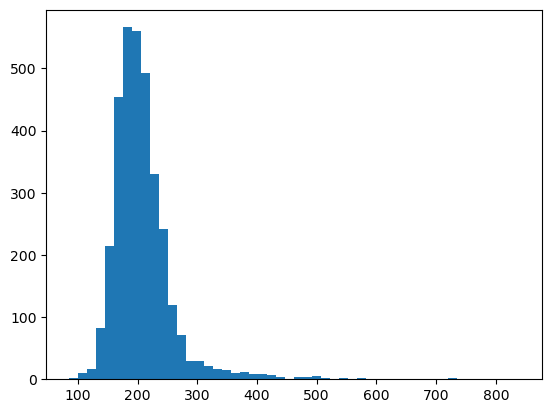

Max source length: 840


In [15]:
import matplotlib.pyplot as plt

len_tokens = []
for data in concatenate_datasets([dataset["train"], dataset["valid"]]):
    len_tokens.append(len(tokenizer.apply_chat_template(data["messages"])))
plt.hist(len_tokens, bins=50)
plt.show()

len_tokens.sort(reverse=True)
print(f"Max source length: {max(len_tokens)}")


In [16]:
cutoff = 328

In [17]:
# (데이터 개수, 데이터 중 328 토큰 이상인 데이터 개수)
print(len(len_tokens), len_tokens.index(cutoff))

3346 103


#### Dataset Filtering

In [18]:
# 토큰 수가 512개 미만인 데이터만 필터링하여 학습
dataset = dataset.filter(lambda sample : len(tokenizer.apply_chat_template(sample["messages"])) < cutoff)

Filter:   0%|          | 0/2912 [00:00<?, ? examples/s]

Filter:   0%|          | 0/434 [00:00<?, ? examples/s]

## Training Arguments

In [40]:
# default : r = 8, lora_alpha = 8
# 적절한 수는 아직 연구중인 단계.
# 다만, 오버피팅 되지 않도록 적절한 dropout값은 주는게 나음.
peft_config = LoraConfig(
        r=256, # default = 8
        lora_alpha=128, # default = 8
        lora_dropout=0.05,
        bias="none",
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"], # "all-linear" 라고만 입력하면, 모든 리니어 레이어가 타겟이 됨.
        task_type="CAUSAL_LM",
)

In [41]:
os.environ["WANDB_PROJECT"] = "scientific qa"  # name your W&B project
os.environ["WANDB_LOG_MODEL"] = "checkpoint"  # log all model checkpoints

# 학습 파라미터.
args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=1,
    per_device_train_batch_size=8,          # 학습시 배치 사이즈
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=8,          # 메모리가 작아 배치사이즈가 적을때 그라디언트를 합쳐서 같은 효과를 내도록 함.
    eval_accumulation_steps=8,
    gradient_checkpointing=True,            # memory 아끼기 위해서 사용.
    optim="adamw_torch_fused",              # fused adamw optimizer 사용.
    logging_steps=5,                       # 학습 한번 돌려보고, 적절한 시간에 맞춰 설정.
    logging_strategy='steps',
    eval_steps=5,                          # validation loss를 보고 싶다면 설정,
    evaluation_strategy='steps',
    save_strategy="steps",                  # checkpoint 저장방식. 추후, trainer.train(resume_from_checkpoint=True) 를 이용해 이어서 학습 가능.
    save_steps=10,
    save_total_limit=2,                     # 스토리지 꽉차니 최대 리밋 설정해주세요.
    learning_rate=4e-5,                     # QLoRA 논문에서 사용한 learning rate 참고
    bf16=True,                              # bfloat16
    tf32=True,                              # tf32
    max_grad_norm=0.3,                      # QLoRA 논문에서 사용한 max gradient norm 참고
    warmup_ratio=0.1,                       # QLoRA 논문에서 사용한 warmup ratio 참고
    lr_scheduler_type="cosine",             # cosine scheduler. 스케쥴러 사용시 성능이 좋다는 실험결과가 있음.
    report_to="wandb",  # Set to 'wandb' to use Weights & Biases
    run_name=f'trial_{datetime.now().strftime("%Y-%m-%d_%H-%M")}',  # Optional: give a name to the wandb run
)


In [42]:
max_seq_length = cutoff

trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["valid"],
    peft_config=peft_config,
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    #compute_metrics = lambda pred: compute_metrics(tokenizer, pred),
    #preprocess_logits_for_metrics = preprocess_logits_for_metrics,
    packing=True,
)

trainer.train()

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

/home/demyank/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: demyank88. Use `wandb login --relogin` to force relogin


/home/demyank/anaconda3/lib/python3.11/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.


Step,Training Loss,Validation Loss
5,2.425800,1.776386
10,1.514100,1.298132
15,1.213900,1.213395
20,1.194900,1.186632
25,1.170600,1.179827


wandb: Adding directory to artifact (./results_ir/checkpoint-10)... Done. 11.1s
/home/demyank/anaconda3/lib/python3.11/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
wandb: Adding directory to artifact (./results_ir/checkpoint-20)... Done. 9.9s
/home/demyank/anaconda3/lib/python3.11/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False

TrainOutput(global_step=27, training_loss=1.4801408538111933, metrics={'train_runtime': 846.7532, 'train_samples_per_second': 2.063, 'train_steps_per_second': 0.032, 'total_flos': 3.967554454290432e+16, 'train_loss': 1.4801408538111933, 'epoch': 0.99})

# Inference

In [12]:
# Load the model and tokenizer
model_name = "beomi/OPEN-SOLAR-KO-10.7B"
checkpoint_path = "./results_ir/checkpoint-20"

# Configuration for model quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)

In [ ]:
# Load the base model
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    attn_implementation="flash_attention_2",
    device_map="auto",
    torch_dtype=torch.bfloat16,
    use_cache=False,
    token=True
)

# Load the fine-tuned PeftModel
model = PeftModel.from_pretrained(model=base_model, model_id=checkpoint_path, device_map='auto')
model.to(device)
model.eval()

In [14]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:

# Example input text
input_text = "### Instruction: 나무의 분류에 대해 조사해 보기 위한 방법은? ### Answer:"
inputs = tokenizer(input_text, return_tensors="pt").to(device)

# Generating output without pipeline
outputs = model.generate(
    input_ids=inputs['input_ids'],
    attention_mask=inputs['attention_mask'],
    max_length=160,
    num_beams=3,
    no_repeat_ngram_size=2,
    early_stopping=True,
    do_sample=True
)

# Decode the generated tokens to a string
answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Answer:", answer)


Answer: ### Instruction: 나무의 분류에 대해 조사해 보기 위한 방법은? ### Answer: 분류는 생물학에서 사용되는 중요한 개념 중 하나입니다. 생물을 분류하는 것은 생물의 구조, 기능, 생태학적 역할 등을 고려하여 이루어집니다. 나무를 분류하기 위해서는 먼저 나무가 속한 과를 파악해야 합니다. 과는 유사한 특징을 공유하는 식물들의 그룹을 의미합니다. 예를 들어, 과일나무는 과실나무과에 속하며, 이 과에는 사과, 배, 복숭아 등의 과일이 속해 있습니다. 다음으로, 나무는 종으로 분류됩니다. 종은 같은 속의 다른 식물들과 구별되는 고유한 특성을 갖는 식물들을 나타냅니다. 이러한 종들은 서로 다른 유전적 특징과 생태
